## Notebook setup

In [137]:
import os
import io
import sys
import warnings
import datetime
import numpy as np
import base64
import dotenv

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# Get the current InteractiveShell instance
#ipython = get_ipython()

# Run a shell command
#result = ipython.getoutput("ls -l")

# Print the output
#print(result)

from IPython.display import HTML

from openbb_terminal.reports import widget_helpers as widgets
from openbb_terminal.sdk import openbb
from openbb_terminal import config_terminal as cfg
from openbb_terminal.helper_classes import TerminalStyle
from openbb_terminal.core.config.paths import USER_ENV_FILE, REPOSITORY_DIRECTORY
import yfinance as yf
import pandas as pd

from jinja2 import Template

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
warnings.filterwarnings("ignore")

# Detect if prediction capabilities are present. If they are not, disable prediction in the rest of the script
# so that the report can still be generated without prediction results.
# predictions = True
# try:
#     openbb.stocks.pred.models
# except Exception as e:
#     predictions = False

# TODO Fix predictions virtual path on api refactored

predictions = False

In [138]:
cfg.theme = TerminalStyle("light", "light", "light")

stylesheet = widgets.html_report_stylesheet()

## Select symbol

In [139]:
# Parameters that will be replaced when calling this notebook
# Do not leave parameters blank as notebook will not run otherwise
#symbol = sys.argv[1]
symbol = "IBM"

# Customize 
exchange_dict = { 'TSLA' : 'NASDAQ',
                  'GOOG' : 'NASDAQ',
                  'MSFT' : 'NASDAQ',
                  'TMDX' : 'NASDAQ'}

similar_companies_dict={
                        'AM' : ['EPD','ET','ENB','PBA','MPLX'],
                        'AR': ['RRC', 'EQT','SWN','CNX','CHK'],
                        'FLNG' : ['GLNG','SFL'],
                        'FTCO': ['GOLD','KGC','AU','AEM','NEM'],
                        'GSL' : ['DAC','CMRE','SFL'],
                        'MP' : ['SGML','LAC','MTRN'],
                        'INSW' : ['FRO','TRMD','EURN'],
                        'IBM' : ['MSFT','GOOGL','INTC','HPQ','AAPL'],
                        'MPLX' : ['AM','EPD','ENB','PBA','ET'],
                        'TRTN' : ['TGH','AER','GATX'],
                        'KNTK' : ['AM','EPD','ENB','PBA','ET','MPLX'],
                        'V' : ['MA','PYPL','SQ','EBAY','FIS'],
                        'ZIM' : ['MATX']
                        }


investor_report_url_dict ={'TRTN': 'https://www.tritoninternational.com/sites/triton-corp/files/investor-presentation-nov-2022.pdf',
                            'GSL': 'https://www.globalshiplease.com/static-files/a226750c-bb27-45e2-8017-a0183e07ad26', 
                            'MP' : 'https://s25.q4cdn.com/570172628/files/doc_presentations/2022/11/MP-3Q22-Earnings-Deck-FINAL.pdf',
                           'TMDX': 'https://investors.transmedics.com/static-files/c4f69c45-77b0-4981-a5a7-b404ab4aae95',
                           'FLNG': 'https://ml-eu.globenewswire.com/Resource/Download/362a3031-2be8-4698-93d0-8066618b20b6',
                            'JXN': 'https://s28.q4cdn.com/568090435/files/doc_presentation/Analyst-Day-Presentation.pdf',                         
                           'EGY' : 'https://d1io3yog0oux5.cloudfront.net/_202883002163863943d602098d2b6e88/vaalco/db/776/7755/pdf/November+IR+Deck+Final+v1.pdf',
                           'EPR' : 'https://investors.eprkc.com/investor-presentation/default.aspx',
                           'MSFT': 'https://view.officeapps.live.com/op/view.aspx?src=https://c.s-microsoft.com/en-us/CMSFiles/SlidesFY22Q2.pptx?version=4a9117e1-04ff-5143-12a0-1ecfc041aa59',
                           'AROC': 'https://s26.q4cdn.com/362558937/files/doc_presentations/2022/11/AROC-Investor-Presentation_RBCWidescreen-vFinal.pdf',
                           'V'   : 'https://s29.q4cdn.com/385744025/files/doc_downloads/2022/Visa-Inc-Fiscal-2022-Annual-Report.pdf',
                           'TSLA': 'https://tesla-cdn.thron.com/static/SVCPTV_2022_Q4_Quarterly_Update_JZPPNX.pdf?xseo=&response-content-disposition=inline%3Bfilename%3D%22TSLA-Q4-2022-Update.pdf%22',
                            'AR' : 'https://d1io3yog0oux5.cloudfront.net/_6cc4d707f40f7cc56aebe36b019cb270/anteroresources/db/641/5970/pdf/AR+Investor+Presentation_Dec_12.01.2022_vF3.pdf'}

morningstar_report_url_dict ={'TSLA': 'https://drive.google.com/file/d/1Hppn9KbAXpg-44Z1MGy-e1LXyZQheLXn/preview',
                              'TRTN': 'https://drive.google.com/file/d/1Hppn9KbAXpg-44Z1MGy-e1LXyZQheLXn/preview',
                              'MP' :  'https://drive.google.com/file/d/1X30f9SFsY7dlGSyl-7i1QkItEi-QZBCY/preview',
                              'MSFT': 'https://drive.google.com/file/d/13Ay0BFGV-3RuES6Q1Ak92kKoLgHbAO3k/preview'}

if (symbol in investor_report_url_dict):
    investor_report_url = investor_report_url_dict[symbol]
else:
    investor_report_url=""

if (symbol in morningstar_report_url_dict):
    morningstar_report_url = morningstar_report_url_dict[symbol]
else:
    morningstar_report_url= ""

df_data = openbb.stocks.fa.data(symbol)
long_name = df_data.at["Company","Values"]
sector =  df_data.at["Sector","Values"]
industry = df_data.at["Industry","Values"]

if (symbol in exchange_dict):
    exchange=exchange_dict[symbol]
else:
    exchange = "NYSE"

report_name = f"{symbol}".upper()

In [140]:
if "." in symbol:
    import sys

    sys.exit(0)
symbol = symbol.upper()

In [141]:
ticker_data = openbb.stocks.load(
    symbol=symbol, start_date=datetime.datetime.now() - datetime.timedelta(days=18 * 30)
)
ticker_data = openbb.stocks.process_candle(data=ticker_data)

author = ""
report_title = f"Investment Research Report on {symbol.upper()}"
report_date = datetime.datetime.now().strftime("%d %B, %Y")
report_time = datetime.datetime.now().strftime("%H:%M")
report_timezone = datetime.datetime.now(datetime.timezone.utc).astimezone().tzinfo
report_title, report_date, report_time, report_timezone

Loading Daily data for IBM with starting period 2021-08-12.

('Investment Research Report on IBM',
 '02 February, 2023',
 '22:30',
 datetime.timezone(datetime.timedelta(days=-1, seconds=68400), 'Eastern Standard Time'))

## Data

In [142]:
(
    df_year_estimates,
    df_quarter_earnings,
    df_quarter_revenues,
) = openbb.stocks.dd.est(symbol=symbol)
df_quarter_revenues

,Previous Quarter,Current Quarter,Next Quarter,Current Year,Next Year
QUARTER REVENUES ESTIMATES,,,,,
Date,ending 12/31/22,ending 03/31/23,ending 06/30/23,ending 12/31/25,-
No. of Analysts,12,11,11,6,-
Average Estimate,"16,151 USD","14,359 USD","15,753 USD","67,590 USD",-
Year Ago,"16,695 USD","14,197 USD","15,535 USD",-,-
Publish Date,1/25/2023,4/19/2023,7/19/2023,-,-


In [143]:
display_year = sorted(df_year_estimates.columns.tolist())[:3]
df_year_estimates = df_year_estimates[display_year].head(5)

In [144]:
tables = openbb.etf.news(f"{long_name}", 20)
for table in tables:
    table[0].loc["link"] = (
        table[0].loc["link"].apply(lambda x: f'<a href="{x}">{x}</a>')
    )

104 news articles for  International Business Machines Corporation were found since 2023-01-26

In [145]:
df_institutional_shareholders = openbb.stocks.fa.shrs(symbol, holder="institutional")
df_institutional_shareholders.index += 1
df_institutional_shareholders

,Holder,Shares,Date Reported,Stake,Value
1,"Vanguard Group, Inc. (The)",79.079 M,2022-09-29,8.75 %,10.786 B
2,Blackrock Inc.,69.911 M,2022-09-29,7.73 %,9.535 B
3,State Street Corporation,53.183 M,2022-09-29,5.88 %,7.254 B
4,"Charles Schwab Investment Management, Inc.",18.432 M,2022-09-29,2.04 %,2.514 B
5,"Geode Capital Management, LLC",15.639 M,2022-09-29,1.73 %,2.133 B
6,Morgan Stanley,13.508 M,2022-09-29,1.49 %,1.842 B
7,JP Morgan Chase & Company,11.019 M,2022-09-29,1.22 %,1.503 B
8,Northern Trust Corporation,10.621 M,2022-09-29,1.17 %,1.449 B
9,Bank of America Corporation,9.265 M,2022-09-29,1.02 %,1.264 B
10,Bank Of New York Mellon Corporation,8.131 M,2022-09-29,0.90 %,1.109 B


In [146]:
openbb.stocks.fa.shrs(symbol)

,Holder,Shares,Date Reported,Stake,Value
0,"Vanguard Group, Inc. (The)",79.079 M,2022-09-29,8.75 %,10.786 B
1,Blackrock Inc.,69.911 M,2022-09-29,7.73 %,9.535 B
2,State Street Corporation,53.183 M,2022-09-29,5.88 %,7.254 B
3,"Charles Schwab Investment Management, Inc.",18.432 M,2022-09-29,2.04 %,2.514 B
4,"Geode Capital Management, LLC",15.639 M,2022-09-29,1.73 %,2.133 B
5,Morgan Stanley,13.508 M,2022-09-29,1.49 %,1.842 B
6,JP Morgan Chase & Company,11.019 M,2022-09-29,1.22 %,1.503 B
7,Northern Trust Corporation,10.621 M,2022-09-29,1.17 %,1.449 B
8,Bank of America Corporation,9.265 M,2022-09-29,1.02 %,1.264 B
9,Bank Of New York Mellon Corporation,8.131 M,2022-09-29,0.90 %,1.109 B


In [147]:
df_institutional_shareholders = openbb.stocks.fa.shrs(symbol)
df_institutional_shareholders.index += 1
df_institutional_shareholders

,Holder,Shares,Date Reported,Stake,Value
1,"Vanguard Group, Inc. (The)",79.079 M,2022-09-29,8.75 %,10.786 B
2,Blackrock Inc.,69.911 M,2022-09-29,7.73 %,9.535 B
3,State Street Corporation,53.183 M,2022-09-29,5.88 %,7.254 B
4,"Charles Schwab Investment Management, Inc.",18.432 M,2022-09-29,2.04 %,2.514 B
5,"Geode Capital Management, LLC",15.639 M,2022-09-29,1.73 %,2.133 B
6,Morgan Stanley,13.508 M,2022-09-29,1.49 %,1.842 B
7,JP Morgan Chase & Company,11.019 M,2022-09-29,1.22 %,1.503 B
8,Northern Trust Corporation,10.621 M,2022-09-29,1.17 %,1.449 B
9,Bank of America Corporation,9.265 M,2022-09-29,1.02 %,1.264 B
10,Bank Of New York Mellon Corporation,8.131 M,2022-09-29,0.90 %,1.109 B


In [148]:
df_sec_filings = openbb.stocks.dd.sec(symbol=symbol)
if (len(df_sec_filings) > 0):
    df_sec_filings = df_sec_filings[["Type", "Category", "Link"]].head(
        5
    )
    df_sec_filings["Link"] = df_sec_filings["Link"].apply(
        lambda x: f'<a href="{x}">{x}</a>'
    )
df_sec_filings

,Type,Category,Link
Filing Date,,,
01/26/2023,8-K,Special Events,"<a href=""https://www.marketwatch.com/investing/stock/ibm/financials/secfilings?docid=16339338"">https://www.marketwatch.com/investing/stock/ibm/financials/secfilings?docid=16339338</a>"
01/25/2023,8-K,Special Events,"<a href=""https://www.marketwatch.com/investing/stock/ibm/financials/secfilings?docid=16335352"">https://www.marketwatch.com/investing/stock/ibm/financials/secfilings?docid=16335352</a>"
01/05/2023,8-K,Special Events,"<a href=""https://www.marketwatch.com/investing/stock/ibm/financials/secfilings?docid=16299508"">https://www.marketwatch.com/investing/stock/ibm/financials/secfilings?docid=16299508</a>"
10/25/2022,10-Q,Quarterly Reports,"<a href=""https://www.marketwatch.com/investing/stock/ibm/financials/secfilings?docid=16150465"">https://www.marketwatch.com/investing/stock/ibm/financials/secfilings?docid=16150465</a>"
10/20/2022,8-K,Special Events,"<a href=""https://www.marketwatch.com/investing/stock/ibm/financials/secfilings?docid=16144072"">https://www.marketwatch.com/investing/stock/ibm/financials/secfilings?docid=16144072</a>"


In [149]:
df_analyst = openbb.stocks.dd.analyst(symbol=symbol)

In [150]:
df_rating = openbb.stocks.dd.rating(symbol)
df_rating

,Rating,DCF,ROE,ROA,DE,PE,PB
date,,,,,,,
2023-02-01,Buy,Strong Buy,Sell,Neutral,Strong Buy,Strong Sell,Strong Buy
2023-01-31,Buy,Strong Buy,Sell,Neutral,Strong Buy,Strong Sell,Strong Buy
2023-01-30,Buy,Strong Buy,Sell,Neutral,Strong Buy,Strong Sell,Strong Buy
2023-01-27,Buy,Strong Buy,Sell,Neutral,Strong Buy,Strong Sell,Strong Buy
2023-01-26,Buy,Strong Buy,Sell,Neutral,Strong Buy,Strong Sell,Strong Buy
...,...,...,...,...,...,...,...
2003-10-06,Strong Buy,Strong Buy,Neutral,Neutral,Strong Buy,Strong Buy,Strong Buy
2003-10-03,Strong Buy,Strong Buy,Neutral,Neutral,Strong Buy,Strong Buy,Strong Buy
2003-10-02,Strong Buy,Strong Buy,Neutral,Neutral,Strong Buy,Strong Buy,Strong Buy


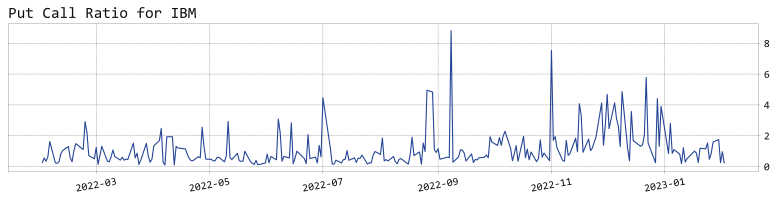

In [151]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.options.pcr_chart(
    symbol,
    window=30,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
pcr_chart = f.getvalue().decode("utf-8")

In [152]:
expiry_dates = openbb.stocks.options.expirations(symbol)
if (len(expiry_dates) > 0):
    exp = expiry_dates[0]
    option_chain = openbb.stocks.options.chains(symbol, expiration=exp)
else:
    option_chain = pd.DataFrame()


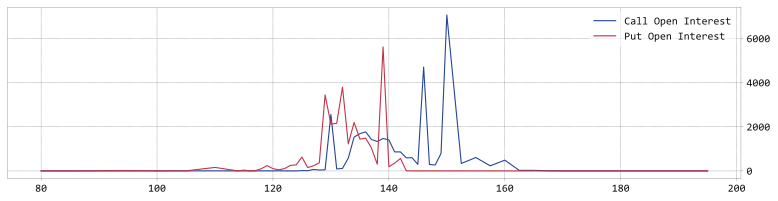

In [153]:
if not option_chain.empty:
    fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
    ax.plot(
        option_chain["strike"], option_chain["c_Openinterest"], label="Call Open Interest"
    )
    ax.plot(
        option_chain["strike"], option_chain["p_Openinterest"], label="Put Open Interest"
    )
    ax.legend()
    fig.tight_layout()
    f = io.BytesIO()
    fig.savefig(f, format="svg")
    vol_chart = f.getvalue().decode("utf-8")

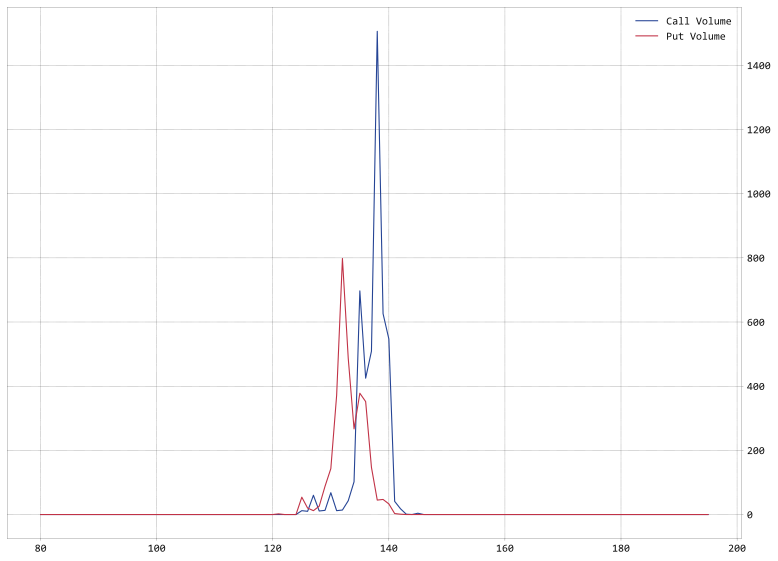

In [154]:
if not option_chain.empty:
    fig, ax = plt.subplots(figsize=(11, 8), dpi=150)
    ax.plot(option_chain["strike"], option_chain["c_Volume"], label="Call Volume")
    ax.plot(option_chain["strike"], option_chain["p_Volume"], label="Put Volume")
    ax.legend()
    fig.tight_layout()
    f = io.BytesIO()
    fig.savefig(f, format="svg")
    voi_chart = f.getvalue().decode("utf-8")

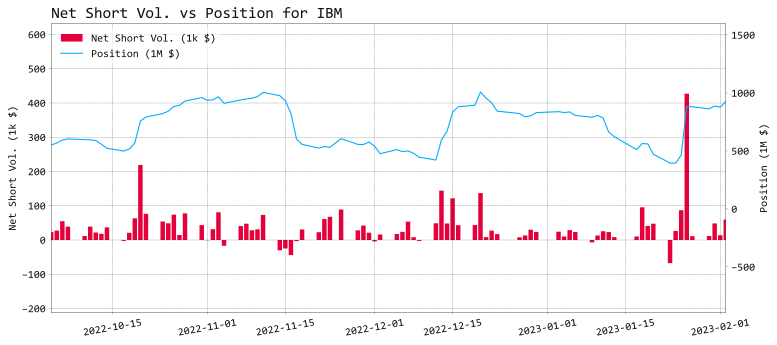

In [155]:
fig, ax1 = plt.subplots(figsize=(11, 5), dpi=150)
ax2 = ax1.twinx()
openbb.stocks.dps.spos_chart(
    symbol=symbol,
    limit=84,
    raw=False,
    export="",
    external_axes=[ax1, ax2],
)
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
net_short_position = f.getvalue().decode("utf-8")

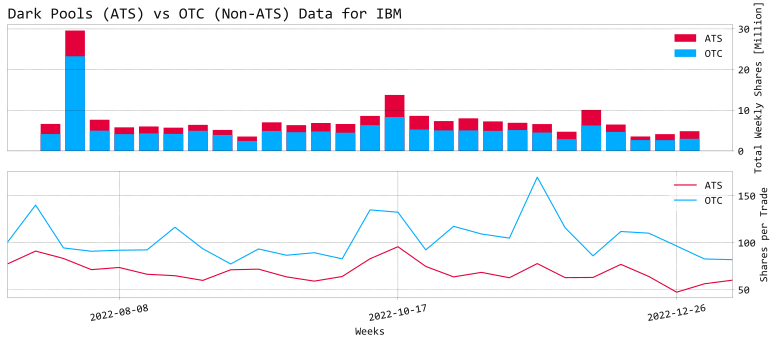

In [156]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.dps.dpotc_chart(symbol=symbol, external_axes=[ax1, ax2])
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
dark_pools = f.getvalue().decode("utf-8")

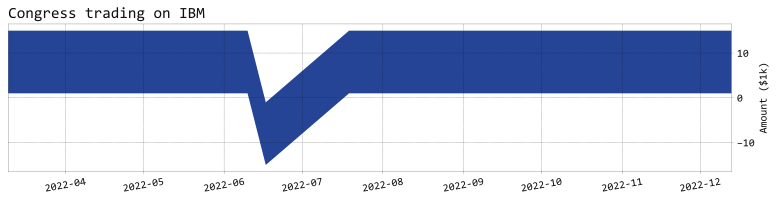

In [157]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.gov.gtrades_chart(
    symbol,
    past_transactions_months=12,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
gtrades_chart = f.getvalue().decode("utf-8")

No government contracts found

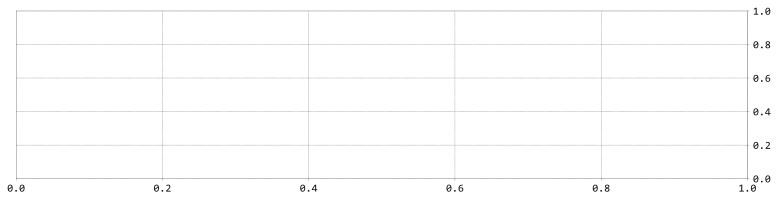

In [158]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.gov.contracts_chart(
    symbol,
    past_transaction_days=365,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
gov_contracts_chart = f.getvalue().decode("utf-8")

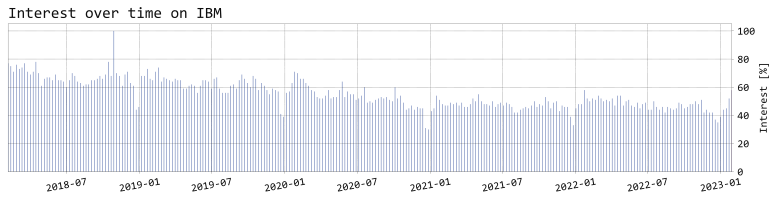

In [159]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.mentions_chart(
    symbol,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
google_mentions_chart = f.getvalue().decode("utf-8")

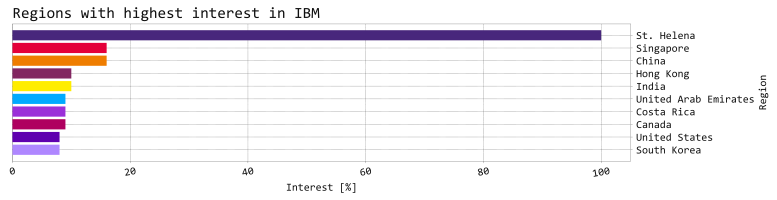

In [160]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.regions_chart(
    symbol,
    limit=10,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
google_regions_chart = f.getvalue().decode("utf-8")

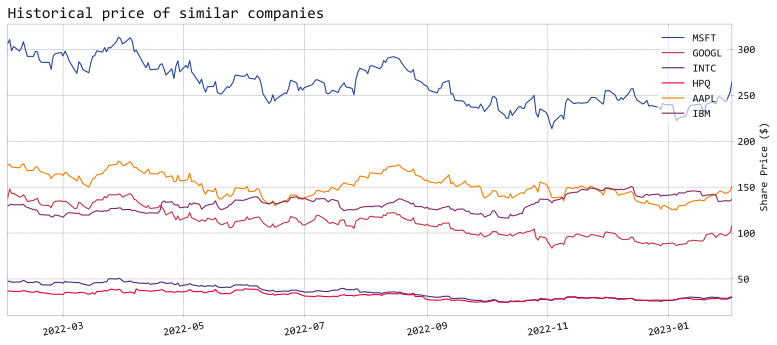

In [161]:

                    
                        
if (symbol in similar_companies_dict):
    similar_companies = similar_companies_dict[symbol]
else:
    similar_companies=openbb.stocks.ca.similar(symbol,source="Polygon")

similar_companies.append(symbol)
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.hist_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
    normalize=False,
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
historical_similar = f.getvalue().decode("utf-8")

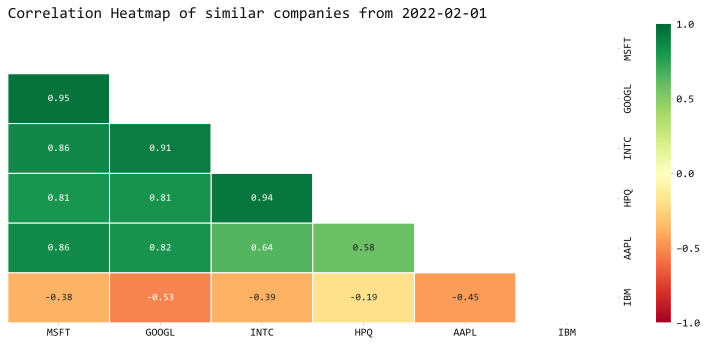

In [162]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.hcorr_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
hcorr_similar = f.getvalue().decode("utf-8")

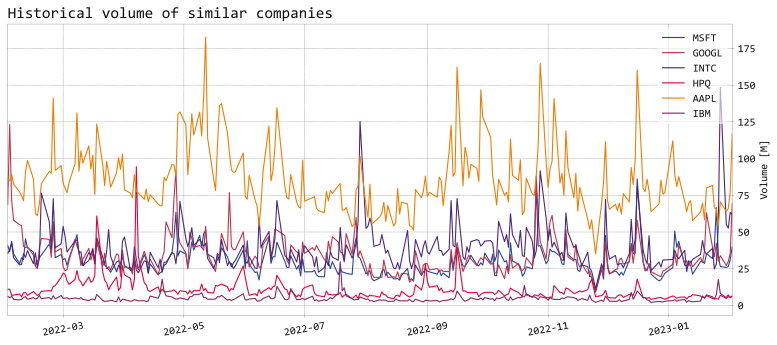

In [163]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.volume_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
vol_similar = f.getvalue().decode("utf-8")

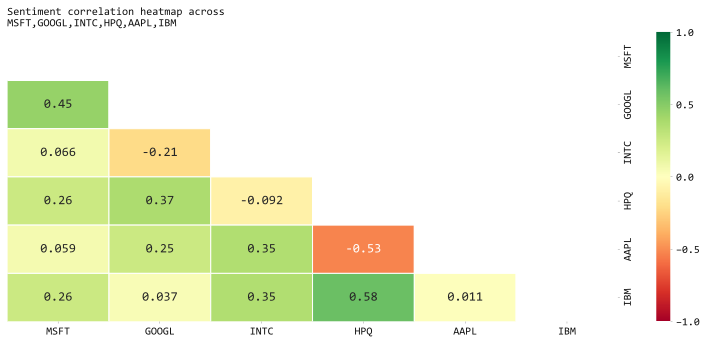

In [164]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=150)
openbb.stocks.ca.scorr_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
scorr_similar = f.getvalue().decode("utf-8")

In [165]:
valuation_comparison = openbb.stocks.ca.screener(similar_companies, "valuation")
valuation_comparison = valuation_comparison.drop(columns=['Change', 'Volume', 'Price', 'EPS next 5Y', 'PEG', 'Sales past 5Y'])
valuation_comparison['Market Cap']=valuation_comparison['Market Cap'].apply(lambda x: "${0:.0f} M".format(x/1000000))

valuation_comparison = valuation_comparison.style.format({"EPS this Y": "${:,.2f}", "EPS next Y": "${:,.2f}", "EPS past 5Y": "${:,.2f}", 
                                                          "P/E": "{:,.2f}", "Fwd P/E":"{:,.2f}", "P/S": "{:,.2f}" , "P/B": "{:,.2f}" , 
                                                          "P/C":"{:,.2f}", "P/FCF": "{:,.2f}"} 
                                                        )
                                                      
#valuation_comparison['EPS this Y']=valuation_comparison['EPS this Y'].apply(lambda x: "${:,.2f}".format(x))

valuation_comparison

,Ticker,Market Cap,P/E,Fwd P/E,P/S,P/B,P/C,P/FCF,EPS this Y,EPS next Y,EPS past 5Y
0,AAPL,$2356180 M,24.72,22.43,5.98,47.73,48.78,24.39,$0.09,$0.09,$0.22
1,GOOGL,$1379340 M,21.81,20.78,4.89,5.53,11.86,22.05,$0.91,$0.10,$0.32
2,HPQ,$30010 M,10.22,8.39,0.48,nan,nan,11.39,$-0.43,$0.11,$0.15
3,IBM,$123370 M,68.43,13.43,2.04,6.14,12.89,53.90,$0.13,$0.07,$-0.16
4,INTC,$133130 M,9.32,15.51,1.91,1.23,4.70,14.42,$-0.60,$1.48,$-0.09
5,MSFT,$1968360 M,29.42,24.36,9.64,10.76,19.78,48.42,$0.20,$0.15,$0.24


In [166]:
financial_comparison = openbb.stocks.ca.screener(similar_companies, "financial")
financial_comparison = financial_comparison.drop(columns=['Change', 'Volume', 'Earnings', 'Price','Market Cap'])
financial_comparison['Dividend']=financial_comparison['Dividend'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['ROA']=financial_comparison['ROA'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['ROE']=financial_comparison['ROE'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['ROI']=financial_comparison['ROI'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['Gross M']=financial_comparison['Gross M'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['Oper M']=financial_comparison['Oper M'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison['Profit M']=financial_comparison['Profit M'].apply(lambda x: "{0:.1f}%".format(x*100))
financial_comparison= financial_comparison.fillna("")
#financial_comparison = financial_comparison.rename(columns={'Gross M': 'Gross Margin', 'Oper M': 'Operating Margin', 'Profit M': 'Profit Margin'})
financial_comparison

,Ticker,Dividend,ROA,ROE,ROI,Curr R,Quick R,LTDebt/Eq,Debt/Eq,Gross M,Oper M,Profit M
0,AAPL,0.6%,28.1%,160.9%,58.3%,0.9,0.8,1.95,2.37,43.3%,30.3%,25.3%
1,GOOGL,nan%,18.7%,26.4%,24.0%,2.5,2.5,0.06,0.06,56.1%,27.8%,23.7%
2,HPQ,3.4%,8.2%,-135.4%,42.5%,0.8,0.5,,,19.6%,7.4%,5.1%
3,IBM,4.8%,5.2%,34.9%,6.5%,1.0,0.9,2.24,2.53,54.0%,10.0%,11.1%
4,INTC,4.8%,4.6%,7.9%,1.8%,1.6,1.2,0.37,0.41,46.6%,3.4%,11.5%
5,MSFT,1.0%,18.8%,39.3%,31.3%,1.9,1.9,0.32,0.35,68.2%,40.5%,33.0%


In [167]:
ownership_comparison = openbb.stocks.ca.screener(similar_companies, "ownership")
ownership_comparison = ownership_comparison.drop(columns=['Market Cap', 'Change', 'Volume', 'Avg Volume', 'Price'])
ownership_comparison= ownership_comparison.fillna("")
ownership_comparison

,Ticker,Outstanding,Float,Insider Own,Insider Trans,Inst Own,Inst Trans,Float Short,Short Ratio
0,AAPL,1.603000e+10,1.582000e+10,0.0007,-0.0573,0.601,-0.0047,0.0077,1.56
1,GOOGL,6.860000e+09,5.900000e+09,0.0778,0.0009,0.786,-0.0021,0.0068,1.26
2,HPQ,9.960000e+08,9.702000e+08,0.0010,-0.2873,0.837,-0.0553,0.0308,4.16
3,IBM,9.041000e+08,9.033300e+08,0.0009,-0.0024,0.585,0.0144,0.0333,6.50
4,INTC,4.140000e+09,4.130000e+09,0.0006,0.0537,0.625,-0.0172,0.0154,1.64
5,MSFT,7.450000e+09,7.440000e+09,0.0006,-0.0355,0.724,0.0047,0.0049,1.20


In [168]:
performance_comparison = openbb.stocks.ca.screener(similar_companies, "performance")
performance_comparison = performance_comparison.drop(columns=['Rel Volume', 'Avg Volume', 'Price','Change','Volume'])
performance_comparison['Perf Week']=performance_comparison['Perf Week'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf Month']=performance_comparison['Perf Month'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf Quart']=performance_comparison['Perf Quart'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf Half']=performance_comparison['Perf Half'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf Year']=performance_comparison['Perf Year'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison['Perf YTD']=performance_comparison['Perf YTD'].apply(lambda x: "{0:.1f}%".format(x*100))
performance_comparison= performance_comparison.fillna("")
performance_comparison

,Ticker,Perf Week,Perf Month,Perf Quart,Perf Half,Perf Year,Perf YTD,Volatility W,Volatility M,Recom
0,AAPL,4.8%,20.6%,0.1%,-9.2%,-13.6%,16.1%,0.0240,0.0255,2.0
1,GOOGL,10.5%,20.9%,19.1%,-8.8%,-21.7%,22.1%,0.0260,0.0272,1.8
2,HPQ,6.1%,15.1%,10.6%,-6.6%,-17.8%,14.6%,0.0265,0.0253,
3,IBM,1.4%,-3.6%,-1.3%,3.1%,0.6%,-3.2%,0.0159,0.0173,2.4
4,INTC,0.3%,12.9%,6.7%,-17.3%,-38.3%,14.2%,0.0456,0.0326,3.2
5,MSFT,6.7%,10.4%,16.0%,-6.3%,-14.3%,10.3%,0.0231,0.0246,1.8


In [169]:
try:
    df_related_queries = openbb.stocks.ba.queries(symbol)
    df_related_queries.index += 1
    df_related_queries.index
except:
    pass

In [170]:
try:
    df_rising_queries = openbb.stocks.ba.rise(symbol)
    df_rising_queries.index += 1
    df_rising_queries
except:
    pass

No quarterly government contracts found

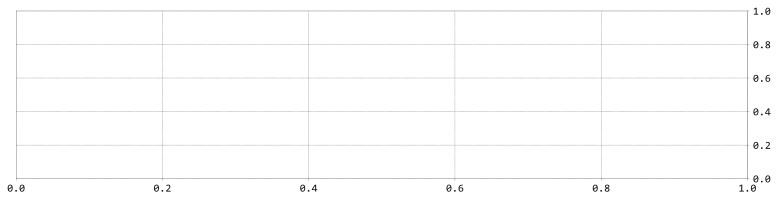

In [171]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.gov.histcont_chart(
    symbol,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
gov_histcont_chart = f.getvalue().decode("utf-8")

In [172]:
df_lobbying = openbb.stocks.gov.lobbying(symbol, limit=5)
df_lobbying

,Date,Ticker,Client,Amount,Issue,Specific_Issue
0,2006-08-10,IBM,INTL BUSINESS MACHINES CORP,0.0,None,None
1,2001-03-15,IBM,INTL BUSINESS MACHINES CORP (IBM),60000.0,Budget/Appropriations \n Copyright/Patent/Trademark \n Taxation/Internal Revenue Code,
2,2001-02-14,IBM,INTL BUSINESS MACHINES CORP,0.0,None,None
3,2001-01-18,IBM,INTL BUSINESS MACHINES CORP (IBM),60000.0,Copyright/Patent/Trademark \n Taxation/Internal Revenue Code \n Budget/Appropriations,
4,2000-08-15,IBM,INTL BUSINESS MACHINES CORP,0.0,None,None


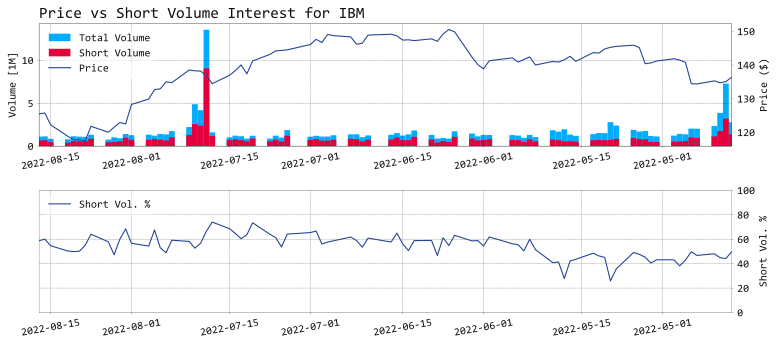

In [173]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
ax3 = ax1.twinx()
openbb.stocks.dps.psi_sg_chart(
    symbol=symbol,
    external_axes=[ax1, ax2, ax3],
)
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
price_vs_short_interest = f.getvalue().decode("utf-8")

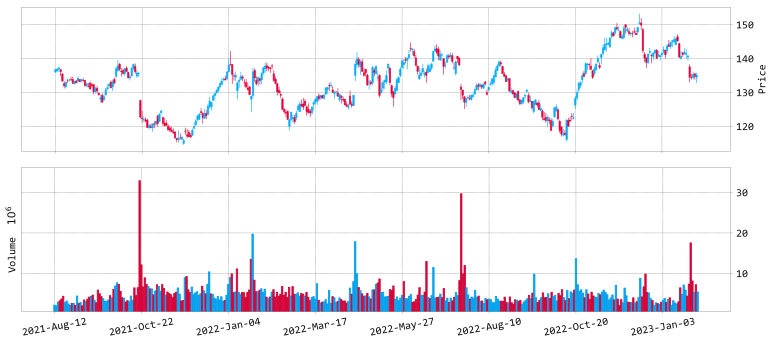

In [174]:
fig, (candles, volume) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.candle(
    symbol=symbol,
    data=ticker_data,
    use_matplotlib=True,
    external_axes=[candles, volume],
)
candles.set_xticklabels("")
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
price_chart = f.getvalue().decode("utf-8")

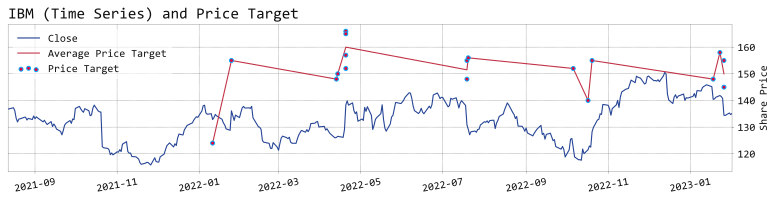

In [175]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.dd.pt_chart(
    symbol=symbol,
    start_date="2022-01-01",
    data=ticker_data,
    limit=10,
    raw=False,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
price_target_chart = f.getvalue().decode("utf-8")

In [176]:
df = openbb.stocks.dd.pt(symbol=symbol)
avg_ratings_last_30_days = 0
days = 0
if not df.empty:
    df_ratings = df[datetime.datetime.now() - datetime.timedelta(days=days) :]
    while df_ratings.empty:
        days += 30
        df_ratings = df[datetime.datetime.now() - datetime.timedelta(days=days) :]

        if days > 100:
            break

    if not df_ratings.empty:
        avg_ratings_last_30_days = round(np.mean(df_ratings["Price Target"].values), 2)
    else:
        avg_ratings = 0

last_price = round(ticker_data["Close"][-1], 2)

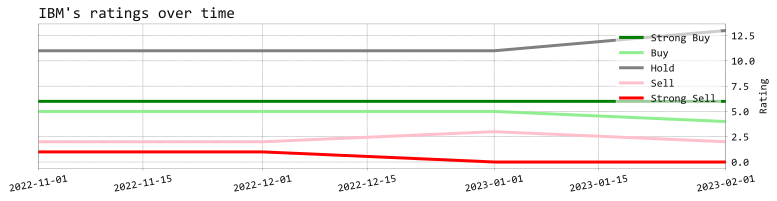

In [177]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.dd.rot_chart(
    symbol=symbol,
    limit=10,
    raw=False,
    export="",
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ratings_over_time_chart = f.getvalue().decode("utf-8")

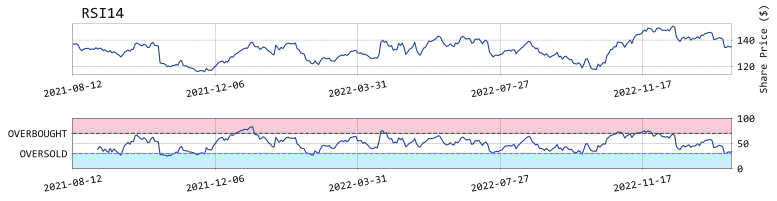

In [178]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 3), dpi=150)
openbb.ta.rsi_chart(ticker_data["Close"], external_axes=[ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ta_rsi = f.getvalue().decode("utf-8")

In [179]:
df = openbb.ta.rsi(ticker_data["Close"])
rsi_value = round(df.values[-1][0], 2)
rsi_value

33.79

In [180]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(
    np.array(range(len(ticker_data["Close"][-30:].index))).reshape(-1, 1),
    ticker_data["Close"][-30:].values,
)
regression_slope = round(model.coef_[0], 2)

In [181]:
import pandas as pd

df_insider = pd.DataFrame.from_dict(openbb.stocks.ins.lins(symbol=symbol)).head(10)
if (df_insider.empty):
    print("empty")
    last_10_insider_trading = 0
else:
    df_insider["Val ($)"] = df_insider["Value ($)"].replace({",": ""}, regex=True)
    df_insider["Trade"] = df_insider.apply(
        lambda row: (-1 * float(row["Val ($)"]))
        if row["Transaction"] == "Sale"
        else (float(row["Val ($)"]) if row["Transaction"] == "Buy" else 0),
        axis=1,
    )
    last_10_insider_trading = round(sum(df_insider["Trade"]) / 1_000_000, 2)
    df_insider = df_insider.drop(columns=["Val ($)", "Trade"])
    df_insider

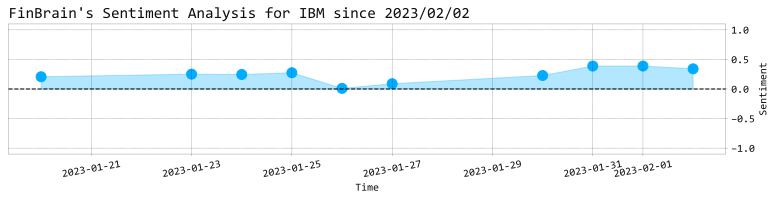

In [182]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.headlines_chart(symbol=symbol, external_axes=[ax])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
finbrain_sentiment = f.getvalue().decode("utf-8")

In [183]:
df_sentiment_finbrain = openbb.stocks.ca.sentiment(symbols=[symbol])
# comment out
#finbrain_sentiment_val = float(df_sentiment_finbrain.values[-1][0])
finbrain_sentiment_val = 0

In [184]:
(
    watchlist_count,
    n_cases,
    n_bull,
    n_bear,
) = openbb.stocks.ba.bullbear(symbol=symbol)
stocktwits_sentiment = f"Watchlist count: {watchlist_count}</br>"
if n_cases > 0:
    stocktwits_sentiment += f"\nLast {n_cases} sentiment messages:</br>"
    stocktwits_sentiment += f"Bullish {round(100*n_bull/n_cases, 2)}%</br>"
    stocktwits_sentiment += f"Bearish {round(100*n_bear/n_cases, 2)}%"
else:
    stocktwits_sentiment += "No messages found"
stocktwits_sentiment

'Watchlist count: 51310</br>\nLast 4 sentiment messages:</br>Bullish 100.0%</br>Bearish 0.0%'

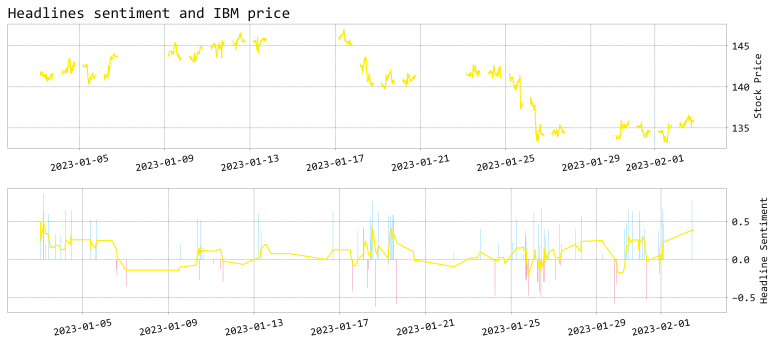

In [185]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.ba.snews_chart(symbol, external_axes=[ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
snews = f.getvalue().decode("utf-8")

In [186]:
ticker_data_all = openbb.stocks.load(
    symbol=symbol,
    start_date=datetime.datetime.now() - datetime.timedelta(days=5 * 12 * 21),
)
ticker_data_all["Returns"] = ticker_data_all["Adj Close"].pct_change()

Loading Daily data for IBM with starting period 2019-08-23.

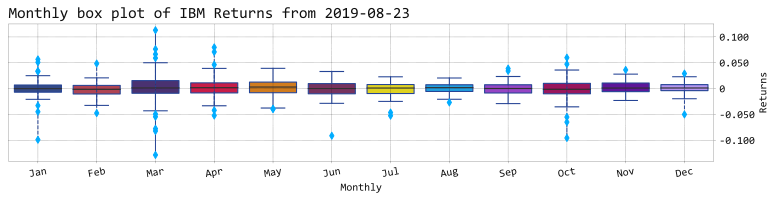

In [187]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.qa.bw(
    ticker_data_all,
    "Returns",
    symbol,
    yearly=False,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bw_month = f.getvalue().decode("utf-8")

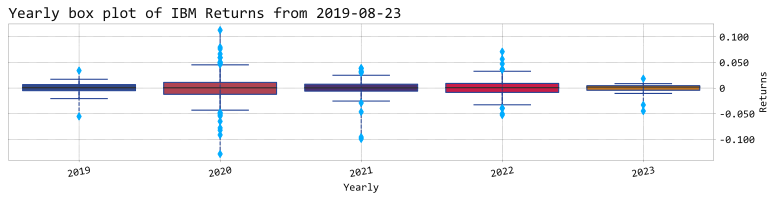

In [188]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.qa.bw(
    ticker_data_all,
    "Returns",
    symbol,
    yearly=True,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bw_year = f.getvalue().decode("utf-8")

In [189]:
income_df = openbb.stocks.fa.income(symbol, source="YahooFinance")
income_df = income_df/1000000
income_df = income_df.applymap("${0:.0f}M".format)

mgmt_df = openbb.stocks.fa.mgmt(symbol)
if (mgmt_df.empty):
    print ("empty")
else:
    mgmt_df["Info"] = mgmt_df["Info"].apply(lambda x: f'<a href="{x}">{x}</a>')
    mgmt_df["Insider Activity"] = mgmt_df["Insider Activity"].apply(
        lambda x: f'<a href="{x}">{x}</a>' if x != "-" else x
    )
try:
    hist_dcf = openbb.stocks.fa.dcf(symbol)
except:
    pass
enterprise_df = openbb.stocks.fa.enterprise(symbol)
score = openbb.stocks.fa.score(symbol)
if score:
    score = round(float(score), 2)

In [190]:
hist_ratios = openbb.stocks.fa.ratios(symbol)
hist_ratios

Fiscal Date Ending,2021,2020,2019,2018,2017
Period,FY,FY,FY,FY,FY
Current ratio,0.879,0.982,1.019,1.286,1.331
Quick ratio,0.661,0.816,0.866,1.113,1.183
Cash ratio,0.198,0.331,0.217,0.298,0.320
Days of sales outstanding,95.318,92.900,112.580,140.162,145.882
Days of inventory outstanding,23.270,17.643,14.534,14.393,13.464
Operating cycle,118.589,110.542,127.113,154.555,159.346
Days of payables outstanding,55.812,47.086,43.952,56.117,54.870
Cash conversion cycle,62.777,63.457,83.162,98.438,104.477
Gross profit margin,0.549,0.483,0.473,0.464,0.458


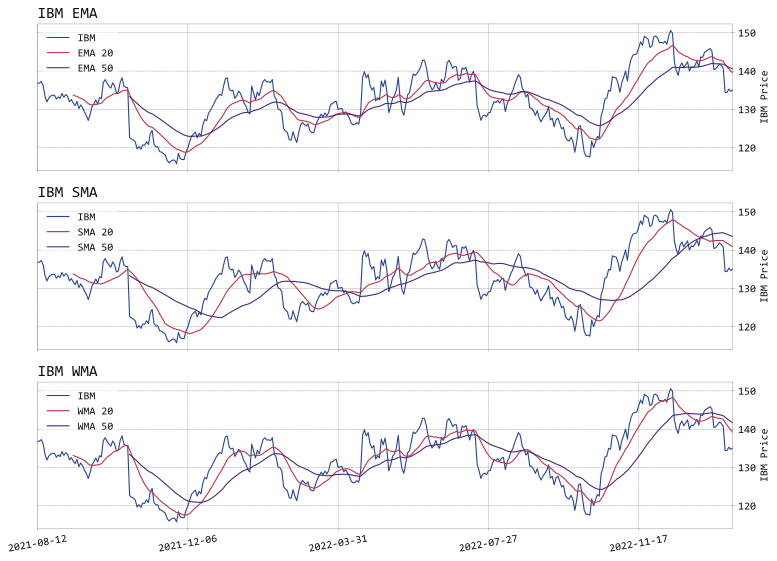

In [191]:
fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=3, ncols=1, figsize=(11, 8), sharex=True, dpi=150
)
openbb.ta.ma(ticker_data["Close"], symbol=symbol, external_axes=[ax1])
openbb.ta.ma(ticker_data["Close"], symbol=symbol, ma_type="SMA", external_axes=[ax2])
openbb.ta.ma(ticker_data["Close"], symbol=symbol, ma_type="WMA", external_axes=[ax3])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ma_chart = f.getvalue().decode("utf-8")

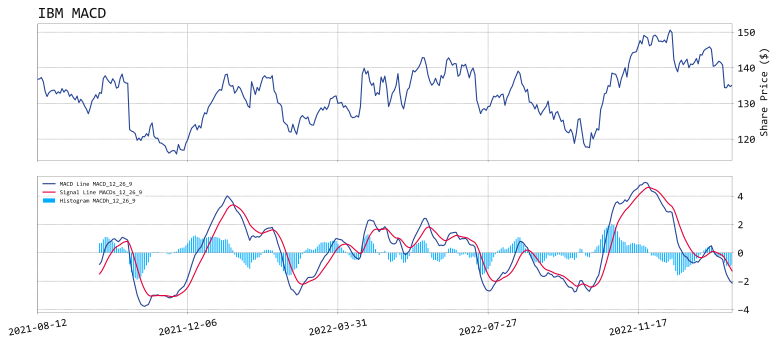

In [192]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), sharex=True, dpi=150)
openbb.ta.macd_chart(ticker_data["Close"], symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
macd_chart = f.getvalue().decode("utf-8")

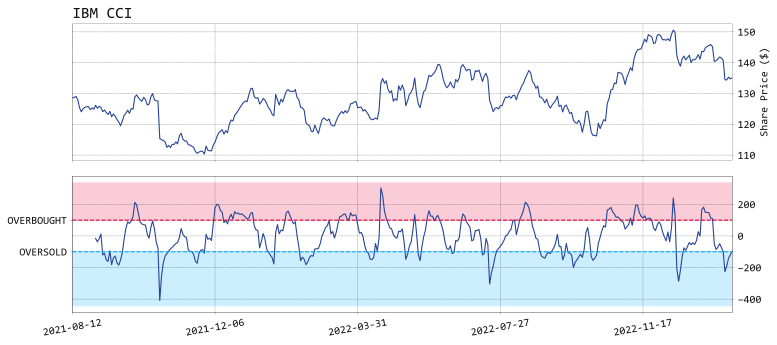

In [193]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), sharex=True, dpi=150)
openbb.ta.cci_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
cci_chart = f.getvalue().decode("utf-8")

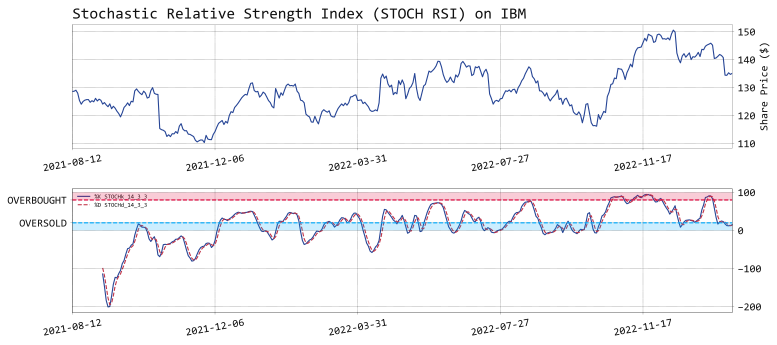

In [194]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
ax2 = ax1.twinx()
openbb.ta.stoch_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
stoch_chart = f.getvalue().decode("utf-8")

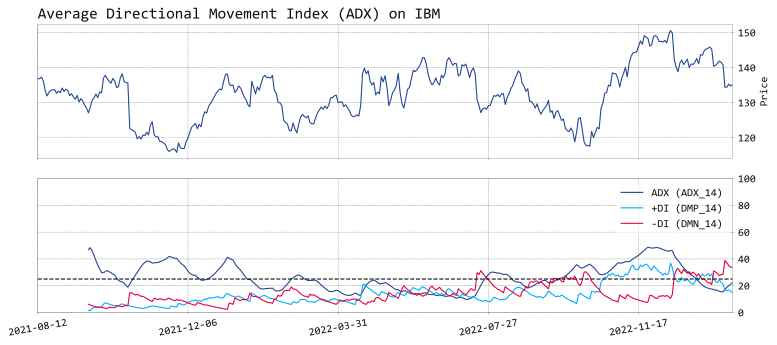

In [195]:
fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(11, 5), dpi=150)
openbb.ta.adx_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
adx_chart = f.getvalue().decode("utf-8")

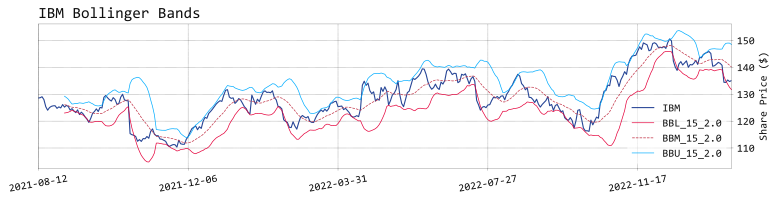

In [196]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.ta.bbands_chart(ticker_data, symbol=symbol, external_axes=[ax])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bbands_chart = f.getvalue().decode("utf-8")

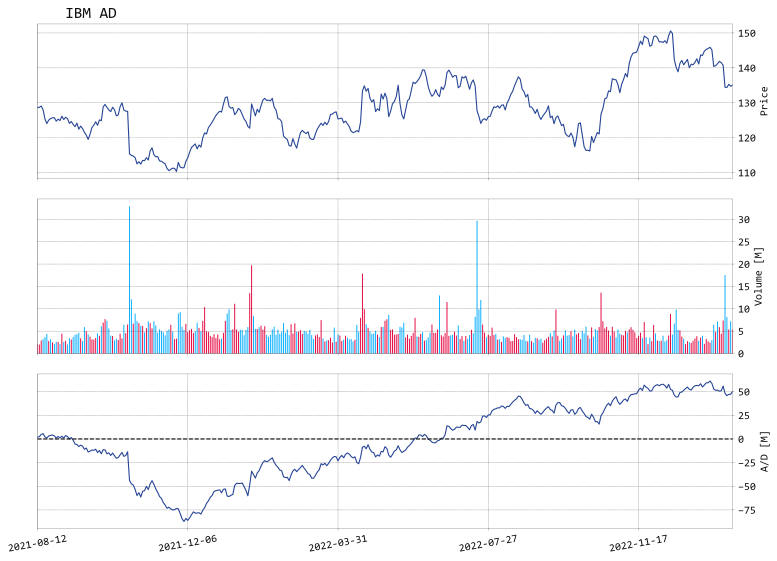

In [197]:
fig, (ax, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(11, 8), dpi=150)
openbb.ta.ad_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ad_chart = f.getvalue().decode("utf-8")

## Render the report template to a file

In [198]:
body =""
    
img = (
    str(REPOSITORY_DIRECTORY)
    + "/openbb_terminal/reports/templates/OpenBB_reports_logo.png"
)
floppy_disk_img = (
    str(REPOSITORY_DIRECTORY) + "/openbb_terminal/reports/templates/floppy-disc.png"
)

htmlcode = f"""
<div class="hcontainer">
    <div class="item">
        <!-- TradingView Widget BEGIN -->
            <div class="tradingview-widget-container">
                <div class="tradingview-widget-container__widget"></div>
                <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/NYSE-{symbol}/" rel="noopener" target="_blank"><span class="blue-text">AR key facts</span></a> by TradingView</div>
                <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-symbol-profile.js" async>
                {{
                "width": "1085",
                "height": "500",
                "colorTheme": "light",
                "isTransparent": false,
                "symbol": "{exchange}:{symbol}",
                "locale": "en"
                }}
                </script>
            </div>
        <!-- TradingView Widget END -->
    </div>
</div>
"""

if (investor_report_url): 
    htmlcode += widgets.row([widgets.h(3, "Investor Presentation for " + symbol)])
    htmlcode += f"""
        <div class="hcontainer">
            <div class="item">
                <iframe src="{investor_report_url}" width="1085" height="700"></iframe>
            </div>
        </div>
            """

            
body += widgets.add_tab("Summary", htmlcode, False)

htmlcode = f"""
<div class="hcontainer">
    <div class="item">
        <!-- TradingView Widget BEGIN -->
        <div class="tradingview-widget-container">
        <div id="tradingview_fceac"></div>
        <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/" rel="noopener" target="_blank"><span class="blue-text">AR stock price</span></a> by TradingView</div>
        <script type="text/javascript" src="https://s3.tradingview.com/tv.js"></script>
        <script type="text/javascript">
        new TradingView.MediumWidget(
            {{
            "symbols": [
                [
                "{long_name}",
                "{exchange}:{symbol}|1D"
                ]
            ],
            "chartOnly": false,
            "width": "1085",
            "height": "700",
            "locale": "en",
            "colorTheme": "light",
            "autosize": false,
            "showVolume": false,
            "hideDateRanges": false,
            "hideMarketStatus": false,
            "scalePosition": "right",
            "scaleMode": "Normal",
            "fontFamily": "-apple-system, BlinkMacSystemFont, Trebuchet MS, Roboto, Ubuntu, sans-serif",
            "fontSize": "10",
            "noTimeScale": false,
            "valuesTracking": "1",
            "chartType": "line",
            "container_id": "tradingview_fceac"
            }}
        );
        </script>
        </div>
        <!-- TradingView Widget END -->
    </div>
</div>
"""

body += widgets.add_tab("Overview", htmlcode, False)

htmlcode = widgets.row([widgets.h(3, "Latest News for " + symbol)])
try:
    for table in tables:
        htmlcode += widgets.row(
            [widgets.h(4, table[1]["title"]) + table[0].to_html(escape=False)]
        )
except:
    pass

htmlcode += widgets.row([widgets.h(3, "Twitter News for " + symbol )])

htmlcode += """
<div class="hcontainer">
    <div class="item">
        <div class="tweet-list">
            {% for tweet in tweets %}
            <div class="tweet">
                <div class="tweet-header">
                    <img src="{{ tweet.user.profile_image_url }}" alt="{{ tweet.user.name }}'s profile picture">
                    <h3>{{ tweet.user.name }}</h3>                   
                </div>       
                <div class="tweet-body">
                    <p>{{ tweet.full_text }}</p>
                </div>   
                {% if tweet.entities.media %}
                    <div class="tweet-media">
                    {% for media in tweet.entities.media %}
                        <img src="{{ media.media_url_https }}" alt="Tweet media">
                    {% endfor %}
                    </div>
                {% endif %}
                <div class="tweet-footer">
                    {% set date = tweet.created_at.strftime('%b %d, %Y at %I:%M %p') %}
                    <p>{{ date }}</p>
                    <a href="https://twitter.com/{{ tweet.user.screen_name }}/status/{{ tweet.id }}" target="_blank">View on Twitter</a>
                </div>
            </div>
            {% endfor %}
        </div>
    </div>
</div>
        """

body += widgets.add_tab("News and Twitter", htmlcode, False)



if(morningstar_report_url):
    htmlcode = widgets.row([widgets.h(3, "Morningstar analysis " + symbol)])
    htmlcode += f"""
            <div class="hcontainer">
                <div class="item">
                <iframe src="{morningstar_report_url}" width="1085" height="700" allow="autoplay"></iframe>
                </div>
            </div>
                """
else:
    htmlCode = widgets.row([widgets.h(3, "Morningstar analysis not available ")])
    
htmlcode += widgets.row([widgets.h(3, "Price Target Chart") + price_target_chart])
htmlcode += widgets.row(
    [widgets.h(3, "Analyst Ratings over time") + ratings_over_time_chart]
)
try:
    htmlcode += widgets.row([widgets.h(3, "Analyst Ratings") + df_analyst.to_html()])
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, "Analyst Recommendations") + df_rating.to_html()]
    )
except:
    pass



body += widgets.add_tab("Analyst Opinions", htmlcode, False)

htmlcode = f"""
<div class="hcontainer">
        <div class="item">
        <!-- TradingView Widget BEGIN -->
            <div class="tradingview-widget-container">
                <div class="tradingview-widget-container__widget"></div>
                <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/financials-overview/" rel="noopener" target="_blank"><span class="blue-text">AR fundamentals</span></a> by TradingView</div>
                <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-financials.js" async>
                {{
                "colorTheme": "light",
                "isTransparent": false,
                "largeChartUrl": "",
                "displayMode": "regular",
                "width": "1085",
                "height": "800",
                "symbol": "{exchange}:{symbol}",
                "locale": "en"
                }}
                </script>
            </div>
        <!-- TradingView Widget END -->
    </div>
</div>
"""

try:
    htmlcode += widgets.row(
        [widgets.h(3, "Estimates") + df_year_estimates.head().to_html()]
    )
except:
    pass

htmlcode += widgets.row(
    [widgets.h(3, "Earnings") + df_quarter_earnings.head().to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, "Revenues") + df_quarter_revenues.head().to_html()]
)
try:
    htmlcode += widgets.row(
        [
            widgets.h(3, "Major Institutional Shareholders")
            + df_institutional_shareholders.head().to_html()
        ]
    )
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, f"Historical DCF for {symbol}") + hist_dcf.to_html()]
    )
except:
    pass
htmlcode += widgets.row(
    [widgets.h(3, f"Enterprise data for {symbol}") + enterprise_df.to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, f"Income Statement for {symbol}") + income_df.to_html()]
)
try:
    htmlcode += widgets.row([widgets.h(3, f"Data for {symbol}") + data_df.to_html()])
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, "SEC filings") + df_sec_filings.to_html(escape=False)]
    )
except:
    pass

htmlcode += widgets.row([widgets.h(3, "Ratios") + hist_ratios.to_html(escape=False)])

body += widgets.add_tab("Fundamental Analysis", htmlcode, False)

htmlcode = widgets.row([widgets.h(3, "Put to call ratio") + pcr_chart])
if not option_chain.empty:
    htmlcode += widgets.row(
        [widgets.h(3, "Option Volume for closest expiry date") + vol_chart]
    )
    htmlcode += widgets.row(
        [widgets.h(3, "Volume and Open Interest for closest expiry date") + voi_chart]
    )
try:
    htmlcode += widgets.row([widgets.h(3, "Option Chains") + options_df.to_html()])
except:
    pass
body += widgets.add_tab("Options", htmlcode, False)

htmlcode = widgets.row([net_short_position])
htmlcode += widgets.row([price_vs_short_interest])
body += widgets.add_tab("Shorts", htmlcode, False)

#htmlcode = """
#   <iframe src="https://ycharts.com/companies/TRTN/chart/" width="1085" height="700"></iframe>
#        """
htmlcode = """
    <div class="iframely-embed"><div class="iframely-responsive" style="height: 140px; padding-bottom: 0;"><a href="https://seekingalpha.com/symbol/TRTN/peers/comparison" data-iframely-url="//cdn.iframe.ly/api/iframe?url=https%3A%2F%2Fseekingalpha.com%2Fsymbol%2FTRTN%2Fpeers%2Fcomparison%3Fcompare%3DTRTN%2CGATX%2CHRI%2CMSM%2CBECN%2CAL&key=a26e39d5d46d5d92044fbef9038730d6"></a></div></div><script async src="//cdn.iframe.ly/embed.js" charset="utf-8"></script>
    """
try:
    htmlcode += widgets.row([widgets.h(3, "Valuation Comparison") + valuation_comparison.to_html()])
except:
    pass

try:
    htmlcode += widgets.row([widgets.h(3, "Financials Comparison") + financial_comparison.to_html()])
except:
    pass

try:
    htmlcode += widgets.row([widgets.h(3, "Ownership Comparison") + ownership_comparison.to_html()])
except:
    pass

try:
    htmlcode += widgets.row([widgets.h(3, "Performance Comparison") + performance_comparison.to_html()])
except:
    pass

htmlcode += widgets.row(
    [
        widgets.h(3, f"Price over the past year for companies similar to {symbol}")
        + historical_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Price correlation with similar companies for {symbol}")
        + hcorr_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Volume over the past year for companies similar to {symbol}")
        + vol_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Sentiment correlation with similar companies for {symbol}")
        + scorr_similar
    ]
)


htmlcode += widgets.row(
    [
        widgets.p(
            "Note that similar companies have been found using openbb.stocks.ca.similar"
        )
    ]
)
body += widgets.add_tab("Comparison", htmlcode, False)

htmlcode = f"""
<div class="hcontainer">
        <div class="item">
        <!-- TradingView Widget BEGIN -->
            <div class="tradingview-widget-container">
                <div class="tradingview-widget-container__widget"></div>
                <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/technicals/" rel="noopener" target="_blank"><span class="blue-text">AR stock analysis</span></a> by TradingView</div>
                <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-technical-analysis.js" async>
                {{
                "interval": "1W",
                "width": "1085",
                "isTransparent": false,
                "height": "700",
                "symbol": "{exchange}:{symbol}",
                "showIntervalTabs": true,
                "locale": "en",
                "colorTheme": "light"
                }}
                </script>
            </div>
        <!-- TradingView Widget END -->
    </div>
</div>
        """

htmlcode += widgets.row([widgets.h(3, f"Moving Averages for {symbol}") + ma_chart])
htmlcode += widgets.row([macd_chart])
htmlcode += widgets.row([ta_rsi])
htmlcode += widgets.row([stoch_chart])
htmlcode += widgets.row([cci_chart])
htmlcode += widgets.row([ad_chart])
htmlcode += widgets.row([bbands_chart])
htmlcode += widgets.row([adx_chart])
body += widgets.add_tab("Technical Analysis", htmlcode, False)

try:
    htmlcode = widgets.row(
        [widgets.h(3, "Last Activity") + df_insider.head(10).to_html(col_space="75px")]
    )
except:
    pass
body += widgets.add_tab("Insider Trading", htmlcode, False)

htmlcode = widgets.row([bw_year])
htmlcode += widgets.row([bw_month])
body += widgets.add_tab("Quantitative Analysis", htmlcode, False)


htmlcode = widgets.row([finbrain_sentiment])
htmlcode += widgets.row([snews])
htmlcode += widgets.row(
    [
        widgets.h(3, "Interest in " + symbol + " based on google analytics")
        + google_mentions_chart
    ]
)
htmlcode += widgets.row(
    [widgets.h(3, f"Regions with highest interest in {symbol}") + google_regions_chart]
)
try:
    htmlcode += widgets.row(
        [
            widgets.h(3, f"Top queries related to {symbol}")
            + df_related_queries.to_html()
        ]
    )
    htmlcode += widgets.row(
        [
            widgets.h(3, f"Top rising queries related to {symbol}")
            + df_rising_queries.to_html()
        ]
    )
except:
    pass
htmlcode += widgets.row(
    [widgets.h(3, f"Stocktwits sentiment for {symbol}") + stocktwits_sentiment]
)
body += widgets.add_tab("Behavioural Analysis", htmlcode, False)

htmlcode = """
    <iframe src="https://docs.google.com/spreadsheets/d/e/2PACX-1vTzYPt7GjAVk-NLvYrDo5OuxcDuaRFejqZ2iT_l2Y3nkKtAgwNO809hYnZhCIxc8XGQSDuGSfc8ZsAy/pubhtml?widget=true&amp;headers=false" width="1085" height="700"></iframe>
        """

body += widgets.add_tab("GSheets", htmlcode, False)

#This code snippet was extracted from OpenBB widget_helpers.py so that the html can be modified to work with the dashboard
body += """
        <script>
        function dmenu2(evt, menu_name) {
            event.preventDefault();
            var i, tabcontent, tablinks;
            tabcontent = document.getElementsByClassName("tabcontent");
            for (i = 0; i < tabcontent.length; i++) {
                tabcontent[i].style.display = "none";
            }
            tablinks = document.getElementsByClassName("tablinks");
            for (i = 0; i < tablinks.length; i++) {
                tablinks[i].className = tablinks[i].className.replace(" active bg-gradient-primary", "");
            }

            document.getElementById(menu_name).style.display = "block";
            evt.currentTarget.className += " active bg-gradient-primary";
        }
        window.onload = function() {
            dmenu2(event, 'Summary');
        };
        </script>"""

f = open("public/templates/report.j2", "r")
template = Template(f.read())
report= template.render(title=report_name, stylesheet=stylesheet, body=body + "</html>")

# to save the results
with open("public/templates/" + report_name + ".html", "w", encoding="utf-8") as fh:
    fh.write(report)

dotenv.load_dotenv(USER_ENV_FILE)
cfg.theme = TerminalStyle(
    os.getenv("OPENBB_MPLSTYLE") or "dark",
    os.getenv("OPENBB_MPFSTYLE") or "dark",
    os.getenv("OPENBB_RICHSTYLE") or "dark",
)